In [1]:
from keras.models import *
from losses import *
import matplotlib.pyplot as plt
%matplotlib inline

/home/bodong/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# from models.dla import DLA
# from models.centernet import centernet, DLA_seg

from models.resnet import centernet
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
shape = (512,512,3)
num_classes = 80
# dla_model = DLA(shape,return_levels=True)
# model, pred_model,debug_model = centernet(shape, dla_model, 20)
# pred_model.predict(np.random.random((1,512,512,3)))
# pred_model.summary()
model, prediction_model, debug_model = centernet(num_classes=num_classes, input_size=shape[0],
                                                     freeze_bn=True,backbone='resnet18')



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[(None, 128, 128, 80), (None, 128, 128, 2), (None, 128, 128, 2), (None, 128, 128, 80), (None, 100, 2), (None, 100), (None, 100, 2), (None, 100), (None, 100)]


In [4]:
debug_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 256, 256, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
pool1 (Max

In [6]:
debug_model.save('./pascal_20_1.6504_2.9600.hdf5')

In [56]:
debug_model.input_shape

(None, 512, 512, 3)

In [10]:
model.load_weights('./ckpt/res18/20200603/coco_167_2.8531_2.8742.h5')

In [6]:
from augmentor.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from augmentor.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from augmentor.object_detection_2d_geometric_ops import Resize
from augmentor.object_detection_2d_patch_sampling_ops import RandomPadFixedAR
from augmentor.object_detection_2d_photometric_ops import ConvertTo3Channels
data_augmentation_chain = DataAugmentationVariableInputSize(512,
                                                            512,
                                                            random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            n_trials_max=3,
                                                            min_scale=0.2,
                                                            max_scale=1.5,
                                                            min_aspect_ratio = 0.8,
                                                            max_aspect_ratio = 1.2,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))
convert_to_3_channels = ConvertTo3Channels()
pad = RandomPadFixedAR(1.0)
resize = Resize(height=512, width=512)
data_augmentation_chain2 = [convert_to_3_channels,
                          pad,
                          resize]

In [7]:


def create_generators(pascal_path=None,random_transform=True,dataset_type='pascal',multi_scale=False,cat_spec_wh=False):
    """
    Create generators for training and validation.

    Args
        args: parseargs object containing configuration for generators.
        preprocess_image: Function that preprocesses an image for the network.
    """
    common_args = {
        'batch_size': 24,
        'input_size': 512,
        'cat_spec_wh':cat_spec_wh,
    }
    coco_path = '/opt/train_data/COCO_data/'
    pascal_path ='/opt/train_data/VOC_data/VOCdevkit/VOC0712/'

    if dataset_type == 'pascal':
        from generators_bodong.pascal import PascalVocGenerator
        train_generator = PascalVocGenerator(
            pascal_path,
            'trainval',
            skip_difficult=True,
            transformations=[data_augmentation_chain],
            **common_args
        )

        validation_generator = PascalVocGenerator(
            pascal_path,
            'test',
            skip_difficult=True,
            shuffle_groups=False,
            transformations=data_augmentation_chain2,
            **common_args
        )
    elif dataset_type == 'csv':
        from generators_bodong.csv_ import CSVGenerator
        train_generator = CSVGenerator(
            args.annotations_path,
            args.classes_path,
            transformations=[data_augmentation_chain],
            **common_args
        )

        if args.val_annotations_path:
            validation_generator = CSVGenerator(
                args.val_annotations_path,
                args.classes_path,
                shuffle_groups=False,
                transformations=data_augmentation_chain2,
                **common_args
            )
        else:
            validation_generator = None
    elif dataset_type == 'coco':
        from generators_bodong.coco import CocoGenerator

        train_generator = CocoGenerator(
            coco_path,
            'train2017',
            transformations=[data_augmentation_chain],
            **common_args
        )

        validation_generator = CocoGenerator(
            coco_path,
            'val2017',
            shuffle_groups=False,
            transformations=data_augmentation_chain2,
            **common_args
        )
    else:
        raise ValueError('Invalid data type received: {}'.format(args.dataset_type))

    return train_generator, validation_generator

In [8]:
train_generator, validation_generator = create_generators(dataset_type='coco')

loading annotations into memory...
Done (t=15.47s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [11]:
from eval.pascal import Evaluate
evaluation = Evaluate(validation_generator, prediction_model)
evaluation.on_epoch_end(0)

Running network: 100% (5000 of 5000) |###| Elapsed Time: 0:04:24 Time:  0:04:24
Parsing annotations: 100% (5000 of 5000) || Elapsed Time: 0:00:01 Time:  0:00:01


('10777 instances of class', u'person', 'with average precision: 0.5412')
('314 instances of class', u'bicycle', 'with average precision: 0.2161')
('1918 instances of class', u'car', 'with average precision: 0.3064')
('367 instances of class', u'motorcycle', 'with average precision: 0.4007')
('143 instances of class', u'airplane', 'with average precision: 0.5639')
('283 instances of class', u'bus', 'with average precision: 0.5262')
('190 instances of class', u'train', 'with average precision: 0.5730')
('414 instances of class', u'truck', 'with average precision: 0.2088')
('424 instances of class', u'boat', 'with average precision: 0.0997')
('634 instances of class', u'traffic light', 'with average precision: 0.1566')
('101 instances of class', u'fire hydrant', 'with average precision: 0.5986')
('75 instances of class', u'stop sign', 'with average precision: 0.5134')
('60 instances of class', u'parking meter', 'with average precision: 0.2632')
('411 instances of class', u'bench', 'with 

In [58]:
import  keras_resnet
keras_resnet.__path__

['/home/bodong/.local/lib/python2.7/site-packages/keras_resnet']

In [9]:
from eval.coco import evaluate_coco
# use prediction model for evaluation
evaluate_coco(validation_generator, prediction_model)

COCO evaluation: 100%|██████████| 5000/5000 [04:19<00:00, 19.28it/s]


Loading and preparing results...
DONE (t=3.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.45s).
Accumulating evaluation results...
DONE (t=2.80s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

array([3.59728324e-08, 3.59728324e-07, 0.00000000e+00, 0.00000000e+00,
       1.17276177e-07, 0.00000000e+00, 1.79856115e-06, 1.91454890e-06,
       5.44562235e-06, 0.00000000e+00, 1.54228195e-05, 0.00000000e+00])

In [7]:
from keras.callbacks import *
def create_callbacks(training_model, prediction_model, validation_generator, snapshot_path,
                     evaluation=True,dataset_type='voc',snapshots=True):
    """
    Creates the callbacks to use during training.

    Args
        training_model: The model that is used for training.
        prediction_model: The model that should be used for validation.
        validation_generator: The generator for creating validation data.
        args: parseargs args object.

    Returns:
        A list of callbacks used for training.
    """
    callbacks = []


    if evaluation and validation_generator:
        if dataset_type == 'coco':
            from eval.coco import CocoEval
            # use prediction model for evaluation
            evaluation = CocoEval(validation_generator, prediction_model)
        else:
            from eval.pascal import Evaluate
            evaluation = Evaluate(validation_generator, prediction_model)
        callbacks.append(evaluation)

    # save the model
    if snapshots:
        # ensure directory created first; otherwise h5py will error after epoch.
        if not os.path.exists(snapshot_path):
            os.makedirs(snapshot_path)
        checkpoint = ModelCheckpoint(
            os.path.join(
                snapshot_path,
                '{dataset_type}_{{epoch:02d}}_{{loss:.4f}}_{{val_loss:.4f}}.h5'.format(dataset_type=dataset_type)
            ),
            verbose=1,
            # save_best_only=True,
            # monitor="mAP",
            # mode='max'
        )
        callbacks.append(checkpoint)

    # callbacks.append(keras.callbacks.ReduceLROnPlateau(
    #     monitor='loss',
    #     factor=0.1,
    #     patience=2,
    #     verbose=1,
    #     mode='auto',
    #     min_delta=0.0001,
    #     cooldown=0,
    #     min_lr=0
    # ))

    return callbacks

In [8]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=1e-5), loss={'centernet_loss': lambda y_true, y_pred: y_pred})

In [9]:
from datetime import datetime
log_dir_base = './ckpt/'
subdir = datetime.strftime(datetime.now(), '%Y%m%d')
log_dir = os.path.join(log_dir_base, subdir)

callbacks = create_callbacks(
       model,
       prediction_model,
       validation_generator,
       log_dir,
    dataset_type='coco'
    )

In [ ]:
model.fit_generator(
        generator=train_generator,
        steps_per_epoch=20000,
        initial_epoch=0,
        epochs=500,
        verbose=1,
#         callbacks=callbacks,
        workers=1,
        use_multiprocessing=False,
        validation_data=validation_generator
    )

Epoch 1/500
20000/20000 [==============================] - 11585s 579ms/step - loss: 5.7858 - val_loss: 5.3093
Epoch 2/500
20000/20000 [==============================] - 11190s 559ms/step - loss: 5.2855 - val_loss: 4.9450
Epoch 3/500
15110/20000 [=====================>........] - ETA: 45:20 - loss: 5.0177

In [11]:
model.save('./haha.hdf5')

In [23]:
data = validation_generator.__getitem__(0)

In [24]:
inp, hm_input, wh_input,wh_mask_input, reg_input, reg_mask_input, index_input = data[0]

In [33]:
k =4

In [26]:
reg_input.shape

(24, 100, 2)

In [14]:
set(np.reshape(np.argmax(hm_input[k], axis=-1),(-1,)).tolist())

{0, 65, 75}

In [27]:
index_input[k]

array([ 3356.,  7443.,  8231., 10896., 10921., 14609.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.], dtype=float32)

In [16]:
k1 = 0

In [17]:
idx = int(index_input[k][k1])

In [18]:
print idx//128, idx%128

40 67


In [19]:
hm_input[k].reshape((128*128,num_classes))[idx,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [20]:
y_, x_ = idx//128*4, idx%128*4
w,h = wh_input[k][k1]*4
bbox = [x_-w//2,y_-h//2,x_+w//2,y_+h//2]


[44.0, 13.0, 204.0, 507.0]
4 bottle


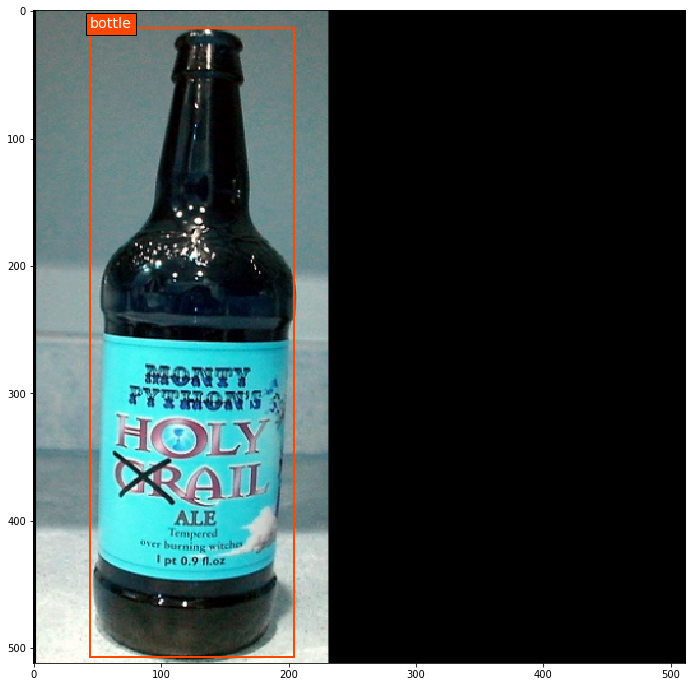

In [34]:
plt.figure(figsize=(20,12))
plt.imshow(inp[k]+0.5)
colors = plt.cm.hsv(np.linspace(0, 1, 80+1)).tolist() # Set the colors for the bounding boxes
classes = train_generator.labels
current_axis = plt.gca()
# # Draw the ground truth boxes in green (omit the label for more clarity)
# for box in batch_labels[i]:
#     xmin = box[1]
#     ymin = box[2]
#     xmax = box[3]
#     ymax = box[4]
#     label = '{}'.format(classes[int(box[0])])
#     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
#     #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Draw the predicted boxes in blue
cls = np.reshape(np.argmax(hm_input[k], axis=-1),(-1,)).tolist()
for k1 in range(0,100):
    if reg_mask_input[k][k1] == 0:
        break
    idx = int(index_input[k][k1])
    y_, x_ = idx//128*4, idx%128*4
    w,h = wh_input[k][k1]*4
    box = [x_-w//2,y_-h//2,x_+w//2,y_+h//2]
    print box
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(cls[idx])]
    print int(cls[idx]),classes[int(cls[idx])]
    label = '{}'.format(classes[int(cls[idx])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [26]:
train_generator.label_to_name(1)

u'bicycle'

In [36]:
result = debug_model.predict(inp[k:k+1])

In [29]:
result[0].shape

(1, 128, 128, 80)

In [30]:
result[1].shape

(1, 128, 128, 2)

In [31]:
result[2].shape

(1, 128, 128, 2)

In [33]:
result[0][:,:,14].max()

0.0061999857

In [40]:
np.max(result[0][0])

0.09821567

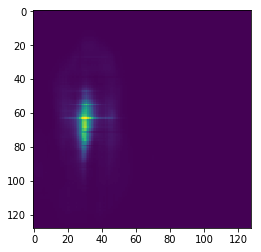

In [37]:
plt.imshow(np.max(result[0][0], axis=-1))

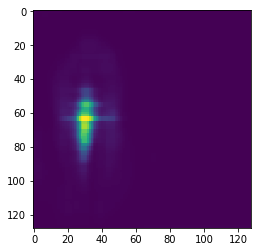

In [44]:
plt.imshow(np.max(hmax[0], axis=-1))

In [45]:
keep = heat==hmax

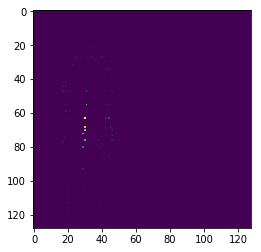

In [48]:
plt.imshow(np.max(heat[0]*keep[0], axis=-1))

In [43]:
heat = result[0]
hmax = np.zeros_like(heat)
b, h, w, c = heat.shape
for batch in range(b):
    for channel in range(c):
        hmax[batch,:,:,channel] = _pool2d(heat[batch,:,:,channel], kernel_size=3, stride=1, padding=1)

In [42]:
from numpy.lib.stride_tricks import as_strided
def _pool2d(A, kernel_size, stride, padding, pool_mode='max'):
    '''
    2D Pooling

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    '''
    # Padding
    A = np.pad(A, padding, mode='constant')

    # Window view of A
    output_shape = ((A.shape[0] - kernel_size)//stride + 1,
                    (A.shape[1] - kernel_size)//stride + 1)
    kernel_size = (kernel_size, kernel_size)
    A_w = as_strided(A, shape = output_shape + kernel_size,
                        strides = (stride*A.strides[0],
                                   stride*A.strides[1]) + A.strides)
    A_w = A_w.reshape(-1, *kernel_size)

    # Return the result of pooling
    if pool_mode == 'max':
        return A_w.max(axis=(1,2)).reshape(output_shape)
    elif pool_mode == 'avg':
        return A_w.mean(axis=(1,2)).reshape(output_shape)

In [89]:
import numpy as np
def focal_loss(hm_pred, hm_true):
    pos_mask = hm_true==1
    neg_mask = hm_true<1
    neg_weights = np.power(1 - hm_true, 4)

    pos_loss = -np.log(np.clip(hm_pred, 1e-4, 1. - 1e-4)) * np.power(1 - hm_pred, 2) * pos_mask
    neg_loss = -np.log(np.clip(1 - hm_pred, 1e-4, 1. - 1e-4)) * np.power(hm_pred, 2) * neg_weights * neg_mask

    num_pos = np.sum(pos_mask)
    pos_loss = np.sum(pos_loss)
    neg_loss = np.sum(neg_loss)
    if num_pos > 0:
        
        cls_loss = (pos_loss + neg_loss) / num_pos
    else:
        cls_loss = neg_loss
    return cls_loss


def reg_l1_loss(y_pred, y_true, indices, mask):
    b, h, w, c = y_pred.shape
    k = indices.shape[1]
    y_pred = np.reshape(y_pred, (h*w, c))
    ii = np.tile(np.range(b)[:, np.newaxis], (1, k))
    idx = np.stack([ii, indices], axis=-1)
    y_pred = np.gather_nd(y_pred, idx)
    mask = np.tile(mask[..., np.newaxis], (1, 1, 2))
    total_loss = np.reduce_sum(np.abs(y_true * mask - y_pred * mask))
    reg_loss = total_loss / (np.sum(mask) + 1e-4)
    return reg_loss


def loss(args):
    hm_pred, wh_pred, reg_pred, hm_true, wh_true, reg_true, reg_mask, indices = args
    hm_loss = focal_loss(hm_pred, hm_true)
    wh_loss = 0.1 * reg_l1_loss(wh_pred, wh_true, indices, reg_mask)
    reg_loss = reg_l1_loss(reg_pred, reg_true, indices, reg_mask)
    total_loss = hm_loss + wh_loss + reg_loss
    return total_loss


In [90]:
focal_loss(result[0], hm_input[k:k+1])

31.119937896728516

In [111]:
hm_input[k].reshape((128*128,20))[8130,:]

array([0.      , 0.      , 0.992218, 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      ], dtype=float32)

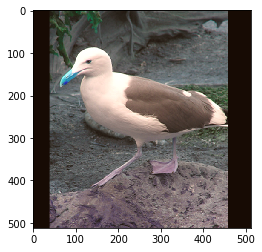

In [100]:
plt.imshow(inp[k]/256+0.5)
